In [2]:
# Read in goal_shot_rows.csv

import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import seaborn as sns
import matplotlib.pyplot as plt

# So Version 0.2 eh?

The goal for this model is to work on the xC, yC columns to standardize them from 0-100 (instead of -100 to 100), the tricky bit here will be also adjusting the previous events co-ordinates to make sure I don't actually break anything. 


Some observations as I go here:

1. The previous event type was generally meant to be "hey was the previous shot a wrister or a slapshot", but is also picking up types of penalties that lead to a penalty shot. I'm wondering if I should include penalty shots in here at all, but will admit it's kinda interesting to see if it has an effect or not. (Really, I should find a way to mux it into a "is penalty shot" variable, but that's probably down the road a bit).
2. Looking at the data a little more closely, I can see I was accidentally including shootouts. Can probably get around this by excluding "Period 5" from the data.
3. Oy vey. I really messed up with the line `input_data2 = input_data2.applymap(lambda x: 1 if x == True else 0)` applying to EVERYTHING, not just the binary values. Time to fix that!
4. Digging more into code, for the 2022 season, only ~85% of recorded shots actually have x/y coordinates. That seems shockingly low!
5. Another 2.9% of shots just have 0,0 as the coordinates! I've read complaints, but truly had no idea it was this bad!
6. Another 13.8% of shots just happen to be at the faceoff dots! The good news is that the ratio of goals to shots is pretty unaltered by this, so we're not going to accidentally train the model to favor one over the other.

7. In total: Only ~70% of goals/shots have actual useful location data
8. Pretty sure my result data was completely broken. Time to try to fix it!
9. Now I'm getting lots of NaNs in my result data, time to try to normalize everything? And try again?


With all this in mind, I don't want to lose another -ton- of data due to previous events not having x/y co-ordinates. So I'll just keep them as NaN (boo). I'll also need to scrub and remove the "this event definitely happened at the faceoff circle" data and convert that to NaN as well. This will hopefully preserve the validity of the "change in angle" info I'm hoping the model will pick up on.

In [3]:
# Read in goal_shot_rows.csv
goal_shot_rows = pd.read_csv('goal_shot_rows.csv')

# remove all instances where Period is 5 or 0
goal_shot_rows = goal_shot_rows[goal_shot_rows['Period'] != 0]
goal_shot_rows = goal_shot_rows[goal_shot_rows['Period'] != 5]

# create a subset of the dataframe, with only the 'Period', 'Seconds_Elapsed', 'Strength', 'Type', 'xC', 'yC'
# 'prev_Event', 'prev_Period', 'prev_Seconds_Elapsed', 'prev_Strength', 'prev_Type', 'prev_xC', 'prev_yC'

input_data = goal_shot_rows[['Event', 'Period', 'Seconds_Elapsed', 'Strength', 'Type', 'xC', 'yC', 'prev_Event', 'prev_Period', 'prev_Seconds_Elapsed', 'prev_Strength', 'prev_Type', 'prev_xC', 'prev_yC']]

result_data = goal_shot_rows['Event']




# Remove all rows of input_data where xC or Yc is NaN
print(len(input_data))
print(input_data['Event'].value_counts())
input_data = input_data.dropna(subset=['xC', 'yC'])
print(len(input_data))
# remove all rows where xC = 0 and yC = 0


input_data = input_data[(input_data['xC'] != 0) | (input_data['yC'] != 0)]


print(len(input_data))
# remove all rows where xC = 69 or -69 and yC is 22 or -22
input_data = input_data[(input_data['xC'] != 69) & (input_data['xC'] != -69) | (input_data['yC'] != 22) & (input_data['yC'] != -22)]
print(len(input_data))
input_data = input_data[(input_data['xC'] != 20) & (input_data['xC'] != -20) | (input_data['yC'] != 22) & (input_data['yC'] != -22)]
print(len(input_data))
print(input_data['Event'].value_counts())

result_data = input_data['Event']
# change result_data to be 1 if it's "GOAL", 0 otherwise
result_data = result_data.apply(lambda x: 1 if x == "GOAL" else 0)

input_data = input_data.drop(columns=['Event'])

print(result_data.value_counts())


87487
Event
SHOT    78688
GOAL     8799
Name: count, dtype: int64
74578
72019
62482
61049
Event
SHOT    54915
GOAL     6134
Name: count, dtype: int64
Event
0    54915
1     6134
Name: count, dtype: int64


In [4]:
# Split out the data between numeric values (can carry forward) and categorical values (need to be turned into binary columns)
input_data_numeric = input_data[['Period', 'Seconds_Elapsed', 'xC', 'yC', 'prev_Seconds_Elapsed', 'prev_xC', 'prev_yC']]
input_data_categorical = pd.DataFrame()

for column in ['Strength', 'Type', 'prev_Event']:
    dummy_columns = pd.get_dummies(input_data[column])
    input_data_categorical = pd.concat([dummy_columns, input_data_categorical], axis=1)

for column in ['prev_Event', 'prev_Strength', 'prev_Type']:
    dummy_columns = pd.get_dummies(input_data[column])
    
    # rename all columns with a prefix of "prev_"
    dummy_columns.columns = ['prev_' + str(col) for col in dummy_columns.columns]

    input_data_categorical = pd.concat([input_data_categorical, dummy_columns], axis=1)


# change all True/False to 1/0
input_data_categorical = input_data_categorical.applymap(lambda x: 1 if x == True else 0)

# combine the two dataframes
input_data_combined = pd.concat([input_data_numeric, input_data_categorical], axis=1)

#set input_data2 to be all floats
input_data_combined = input_data_combined.astype(float)

# # Normalize all columns in input_data_combined
# input_data_combined = (input_data_combined - input_data_combined.mean()) / input_data_combined.std()

C:\Users\JoshG\AppData\Local\Temp\ipykernel_30264\1140079663.py:19: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  input_data_categorical = input_data_categorical.applymap(lambda x: 1 if x == True else 0)


c:\Users\JoshG\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\JoshG\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='xC', ylabel='yC'>

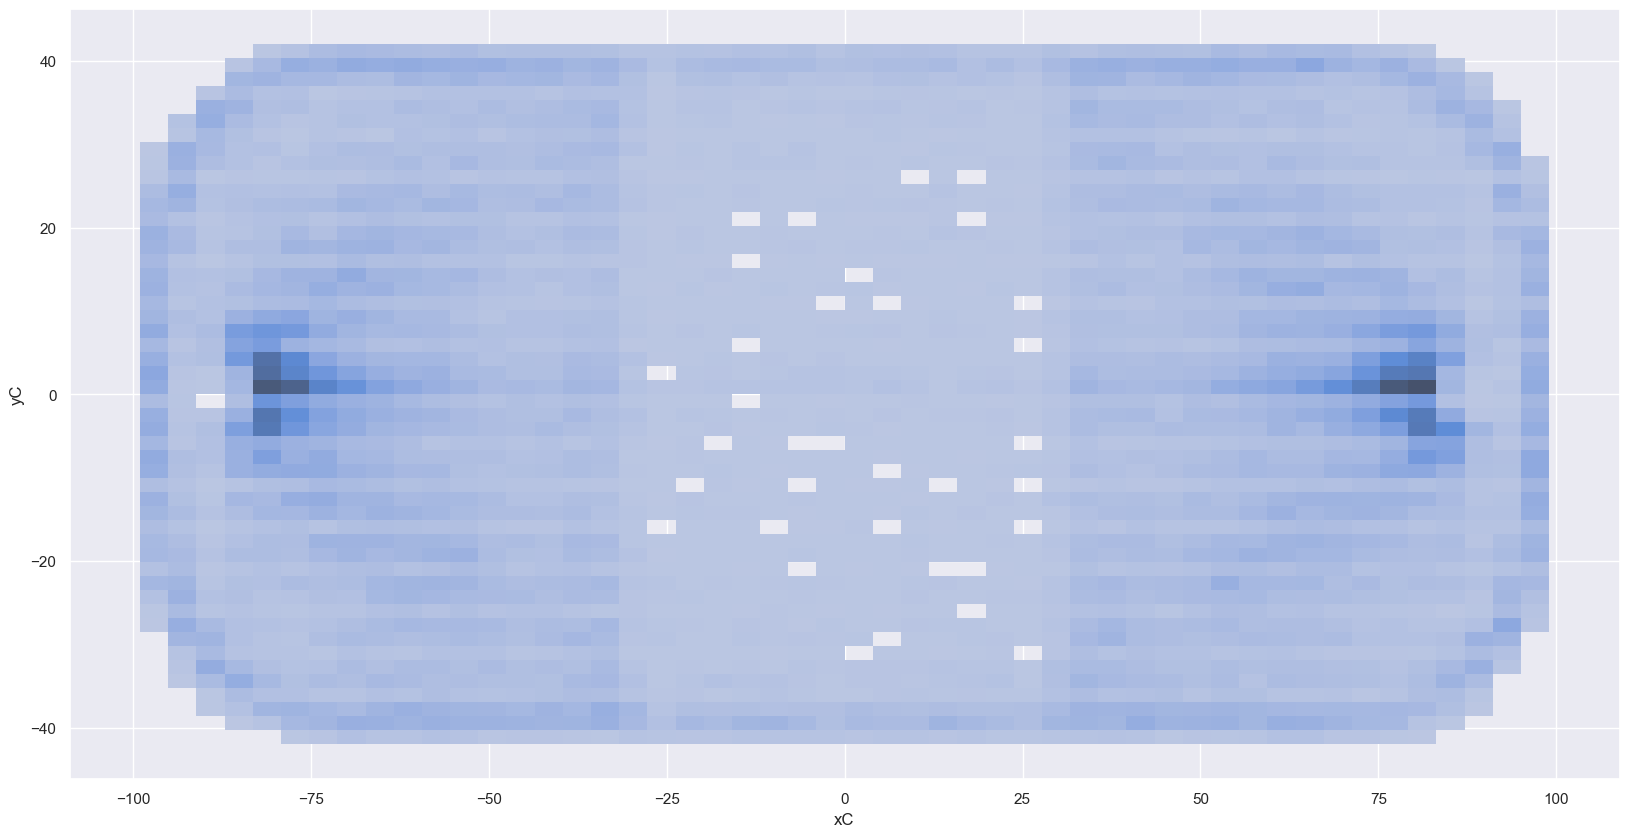

In [5]:
# let's do some data validation, and get the list of columns:
coord_df = pd.concat([input_data_combined['xC'], input_data_combined['yC']], axis=1)
sns.set_theme(rc={'figure.figsize':(20,10)})
sns.histplot(coord_df, x="xC", y="yC", bins=50)
# Get the most common combinations of xC and yC
# print(input_data_combined['xC'].value_counts())
# print(input_data_combined['yC'].value_counts())


In [6]:
# change all NaN numbers to 0
input_data_combined = input_data_combined.fillna(0)

In [31]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

x = torch.tensor(input_data_combined.values, dtype=torch.float32)
y = torch.tensor(result_data.values, dtype=torch.float32)

x.to(device)


y.to(device)



Using device: cuda



tensor([0., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')

In [32]:
model = nn.Sequential(
    nn.Linear(71, 120),
    nn.ReLU(),
    nn.Linear(120, 60),
    nn.ReLU(),
    nn.Linear(60, 1),
    nn.Sigmoid()
)

print(model)

model.to(device)


loss_fn = nn.BCELoss()  # binary cross entropy
loss_fn.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)






#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Sequential(
  (0): Linear(in_features=71, out_features=120, bias=True)
  (1): ReLU()
  (2): Linear(in_features=120, out_features=60, bias=True)
  (3): ReLU()
  (4): Linear(in_features=60, out_features=1, bias=True)
  (5): Sigmoid()
)
NVIDIA GeForce RTX 4080 SUPER
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [42]:
n_epochs = 800000
batch_size = 10000
 
for epoch in range(n_epochs):
    for i in range(0, len(x), batch_size):
        Xbatch = x[i:i+batch_size]
        y_pred = model(Xbatch.cuda())
        ybatch = y[i:i+batch_size]
        #loss = loss_fn(y_pred, ybatch)
        loss = loss_fn(y_pred.squeeze(), ybatch.cuda())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'{epoch}, {loss}')


# compute accuracy (no_grad is optional)
y_pred = model(x.cuda()).cuda()
 
accuracy = (y_pred.round() == y.cuda()).float().mean()
print(f"Accuracy {accuracy}")

torch.save(model.state_dict(), '0421Model_800k.pt')

0, 0.13499286770820618
1, 0.1364826112985611
2, 0.13739322125911713
3, 0.13534580171108246
4, 0.1425292044878006
5, 0.13529659807682037
6, 0.13522551953792572
7, 0.13776566088199615
8, 0.13677917420864105
9, 0.13736572861671448
10, 0.1381804496049881
11, 0.13258378207683563
12, 0.13263428211212158
13, 0.13489043712615967
14, 0.13717269897460938
15, 0.1338752955198288
16, 0.1344766616821289
17, 0.13704490661621094
18, 0.13799066841602325
19, 0.1353798806667328
20, 0.13499903678894043
21, 0.13518834114074707
22, 0.13388027250766754
23, 0.13465984165668488
24, 0.13505631685256958
25, 0.13397197425365448
26, 0.13666874170303345
27, 0.1353932023048401
28, 0.13095428049564362
29, 0.1312296837568283
30, 0.1333773285150528
31, 0.13250331580638885
32, 0.13066835701465607
33, 0.13222068548202515
34, 0.13223659992218018
35, 0.13215313851833344
36, 0.1318289190530777
37, 0.13295051455497742
38, 0.13245899975299835
39, 0.1326562464237213
40, 0.13224636018276215
41, 0.13251081109046936
42, 0.1333266

(0.265, 0.28)

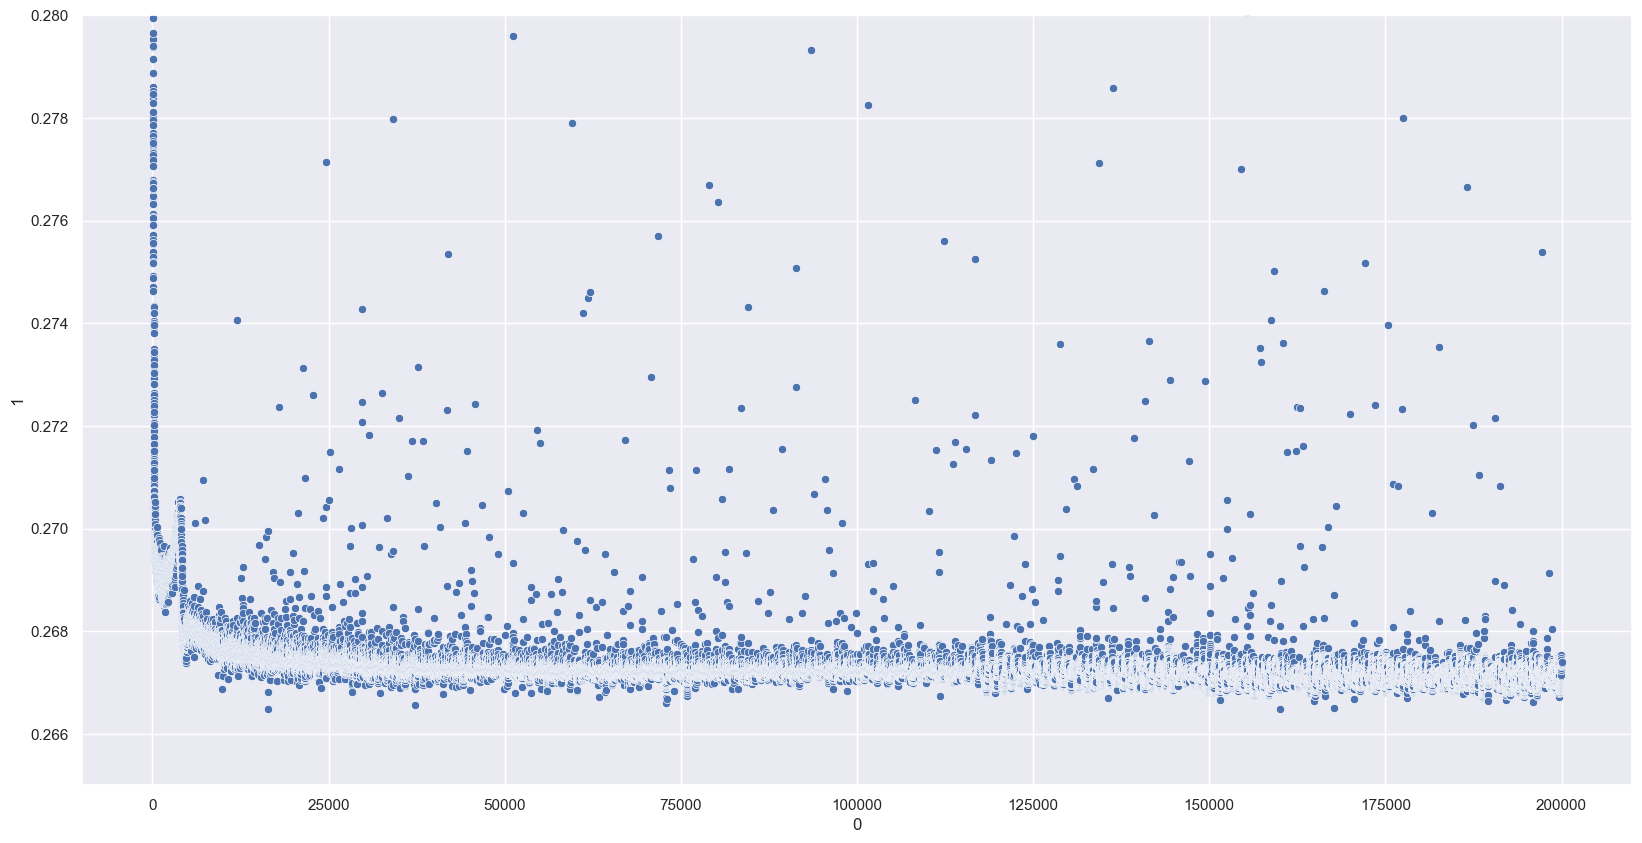

In [63]:
# open 0419Model.csv as a text file, and remove all non-numeric characters
data = ""
with open('0419Model.csv', 'r') as file:
    data = file.read()
    data = data.replace('Finished epoch ', '')
    # write it back to another file
with open('0419Model.csv', 'w') as file:
    file.write(data)


# read in the file as a dataframe
model_data = pd.read_csv('0419Model.csv', header=None)

# create a scatterplot of mode_data
sns.scatterplot(x=model_data[0], y=model_data[1])

# limit the scatterplot y axis to 0.25 to 0.3
plt.ylim(0.265, 0.28)

In [150]:
# Now save the model to a file for future use
torch.save(model.state_dict(), '0421Model.pt')

# Getting Top Players xG

In [47]:
filepath = '0421Model_20k.pt'
model.load_state_dict(torch.load(filepath))
model.eval()
model.cpu()

# Read in goal_shot_rows.csv
val_goal_shot_rows = pd.read_csv('2023-2024_shots.csv')

# remove all instances where Period is 5 or 0
val_goal_shot_rows = val_goal_shot_rows[val_goal_shot_rows['Period'] != 0]
val_goal_shot_rows = val_goal_shot_rows[val_goal_shot_rows['Period'] != 5]

# create a subset of the dataframe, with only the 'Period', 'Seconds_Elapsed', 'Strength', 'Type', 'xC', 'yC'
# 'prev_Event', 'prev_Period', 'prev_Seconds_Elapsed', 'prev_Strength', 'prev_Type', 'prev_xC', 'prev_yC'

val_input_data = val_goal_shot_rows


# Remove all rows of val_input_data where xC or Yc is NaN
print(len(val_input_data))
print(val_input_data['Event'].value_counts())
val_input_data = val_input_data.dropna(subset=['xC', 'yC'])
print(len(val_input_data))
# remove all rows where xC = 0 and yC = 0
val_input_data = val_input_data[(val_input_data['xC'] != 0) | (val_input_data['yC'] != 0)]
print(len(val_input_data))
# remove all rows where xC = 69 or -69 and yC is 22 or -22
val_input_data = val_input_data[(val_input_data['xC'] != 69) & (val_input_data['xC'] != -69) | (val_input_data['yC'] != 22) & (val_input_data['yC'] != -22)]
print(len(val_input_data))
val_input_data = val_input_data[(val_input_data['xC'] != 20) & (val_input_data['xC'] != -20) | (val_input_data['yC'] != 22) & (val_input_data['yC'] != -22)]
print(len(val_input_data))
print(val_input_data['Event'].value_counts())


# write val_input_data to a csv file
val_input_data.to_csv('val_input_data.csv')

val_input_data = val_input_data[['Event', 'Period', 'Seconds_Elapsed', 'Strength', 'Type', 'xC', 'yC', 'prev_Event', 'prev_Period', 'prev_Seconds_Elapsed', 'prev_Strength', 'prev_Type', 'prev_xC', 'prev_yC']]

val_result_data = val_input_data['Event']
# change result_data to be 1 if it's "GOAL", 0 otherwise
val_result_data = val_result_data.apply(lambda x: 1 if x == "GOAL" else 0)

val_input_data = val_input_data.drop(columns=['Event'])


79594
Event
SHOT    71498
GOAL     8096
Name: count, dtype: int64
68051
65765
57383
56113
Event
SHOT    50250
GOAL     5863
Name: count, dtype: int64


In [44]:
# Quick sanity checking
print(val_result_data.value_counts())

Event
0    50250
1     5863
Name: count, dtype: int64


In [48]:

# Split out the data between numeric values (can carry forward) and categorical values (need to be turned into binary columns)
val_input_data_numeric = val_input_data[['Period', 'Seconds_Elapsed', 'xC', 'yC', 'prev_Seconds_Elapsed', 'prev_xC', 'prev_yC']]
val_input_data_categorical = pd.DataFrame()

for column in ['Strength', 'Type', 'prev_Event']:
    dummy_columns = pd.get_dummies(val_input_data[column])
    val_input_data_categorical = pd.concat([dummy_columns, val_input_data_categorical], axis=1)

for column in ['prev_Event', 'prev_Strength', 'prev_Type']:
    dummy_columns = pd.get_dummies(val_input_data[column])
    
    # rename all columns with a prefix of "prev_"
    dummy_columns.columns = ['prev_' + str(col) for col in dummy_columns.columns]

    val_input_data_categorical = pd.concat([val_input_data_categorical, dummy_columns], axis=1)


# change all True/False to 1/0
val_input_data_categorical = val_input_data_categorical.applymap(lambda x: 1 if x == True else 0)

# combine the two dataframes
val_input_data_combined = pd.concat([val_input_data_numeric, val_input_data_categorical], axis=1)

#set val_input_data2 to be all floats
val_input_data_combined = val_input_data_combined.astype(float)


# For each column in input_data_combined, check if it exists in val_input_data_combined, if not add it as all 0s
for column in input_data_combined.columns:
    if column not in val_input_data_combined.columns:
        val_input_data_combined[column] = 0

# reduce val_input_data_combined to have the same columns as input_data_combined
val_input_data_combined = val_input_data_combined[input_data_combined.columns]

# change all NaN numbers to 0
val_input_data_combined = val_input_data_combined.fillna(0)

C:\Users\JoshG\AppData\Local\Temp\ipykernel_30264\69145011.py:19: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  val_input_data_categorical = val_input_data_categorical.applymap(lambda x: 1 if x == True else 0)


In [175]:
print(val_result_data)
# Get counts of most popular values in val_result_data
print(val_result_data.value_counts())

0        0
1        0
2        0
6        0
7        1
        ..
80087    0
80088    0
80089    1
80090    0
80091    0
Name: Event, Length: 56113, dtype: int64
Event
0    50250
1     5863
Name: count, dtype: int64


In [49]:
# For first 1000 rows of val_input_data_combined, predict if it's a goal or not
x = torch.tensor(val_input_data_combined.values, dtype=torch.float32)
y = torch.tensor(val_result_data.values, dtype=torch.float32)

# for first row of val_input_data_combined, predict if it's a goal or not

probablity_table = pd.DataFrame()
nan_count = 0

for i in range(1000):
    y_pred = model(x[i])
    # print(f"Goal status is {y[i]} and prediction is {y_pred[0]}")
    
    line = pd.DataFrame({'Goal': [y[i].item()], 'Chance': [y_pred[0].item()]})

    # check if y_pred is NaN
    if y_pred[0].item() != y_pred[0].item():
        print("y_pred is NaN")
        # line = pd.DataFrame({'Goal': [y[i].item()], 'Chance': [0.0]})
        nan_count += 1

    probablity_table = pd.concat([probablity_table, line])

# sort probablity_table by 'Chance' in descending order
# probablity_table = probablity_table.sort_values(by='Chance', ascending=False)

# write probablity_table to a csv file
probablity_table.to_csv('0421Model_probabilities.csv', index=False)

print(probablity_table)
print(nan_count)


    Goal        Chance
0    0.0  1.474540e-14
0    0.0  6.722108e-02
0    0.0  1.186863e-05
0    0.0  3.674954e-02
0    1.0  1.659209e-02
..   ...           ...
0    0.0  3.886895e-02
0    1.0  1.922898e-01
0    0.0  7.300915e-03
0    0.0  4.014149e-02
0    0.0  1.292508e-01

[1000 rows x 2 columns]
0


In [51]:
# get the accuracy of the model
accuracy = (y_pred.round() == y).float().mean()
print(f"Accuracy {accuracy}")

Accuracy 0.8955144286155701


56113
56113
Type
WRIST SHOT     31895
SNAP SHOT       8085
SLAP SHOT       6174
BACKHAND        4132
TIP-IN          3916
DEFLECTED        961
WRAP-AROUND      452
Name: count, dtype: int64


<Axes: xlabel='yC', ylabel='Goal_Probability'>

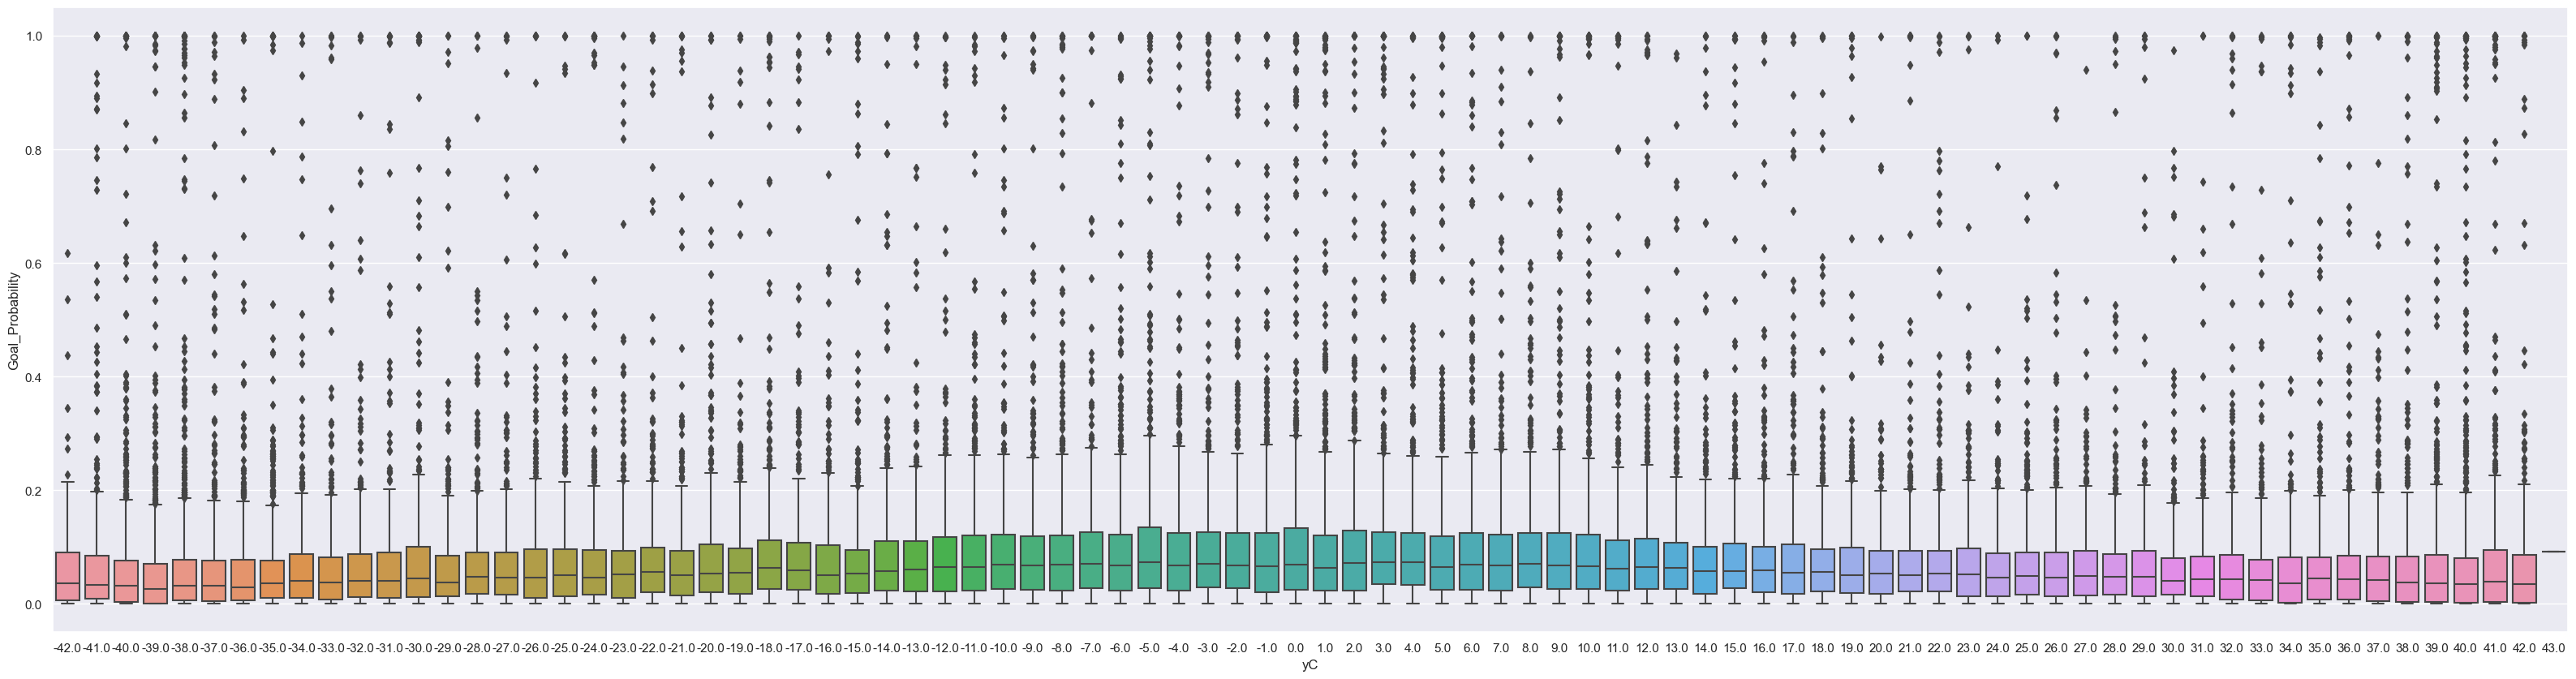

In [194]:
result = model(x)
print(len(result))


print(len(val_input_data))

# add the probability of a goal to val_input_data_combined
val_input_data['Goal_Probability'] = result.detach().numpy()


# print the values of val_input_data["Type"]
print(val_input_data["Type"].value_counts())

# make a boxplot of Goal_Probability vs Type
sns.set_theme(rc={'figure.figsize':(40,10)})
sns.boxplot(x=val_input_data["yC"], y=val_input_data["Goal_Probability"])
# sns.scatterplot(x=val_input_data["Type"], y=val_input_data["Goal_Probability"])
